In [59]:
import os
import sys 
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Attention #from attention import Attention

import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix


##https://keras.io/examples/timeseries/timeseries_transformer_classification/

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
GPU is available


In [86]:
df1 = pd.read_csv('Stable_Data_CSV.csv')
df2 = pd.read_csv('12w_features.csv')
df_stable = df2[df2.set_index(['participant_id']).index.isin(df1.set_index(['participant_id']).index)]

df_stable['tfi_diff_6w'] = df_stable.iloc[:,17] - df_stable.iloc[:,25] #df_stable.columns.get_loc("tfi_total.2") -->25
df_stable['tfi_diff_12w'] = df_stable.iloc[:,17] - df_stable.iloc[:,33]

df_stable['label_6w'] = np.where(df_stable['tfi_diff_6w']>=13, 1, 0)
df_stable['label_12w'] = np.where(df_stable['tfi_diff_12w']>=13, 1, 0)

df_stable_US = df_stable.loc[(df_stable['arm'] == 1)]
df_stable_WN = df_stable.loc[(df_stable['arm'] == 2)]
print(len(df_stable_US))
print(len(df_stable_WN))

31
30


/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_48968/107019627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stable['tfi_diff_6w'] = df_stable.iloc[:,17] - df_stable.iloc[:,25] #df_stable.columns.get_loc("tfi_total.2") -->25
/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_48968/107019627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stable['tfi_diff_12w'] = df_stable.iloc[:,17] - df_stable.iloc[:,33]
/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_48968/10

In [87]:
df_stable_US=(df_stable_US[['c_3','sl_1','a_2','q_1','tfi_total','c_3.1','sl_1.1','a_2.1','q_1.1','tfi_total.1','c_3.2','sl_1.2','a_2.2','q_1.2','tfi_total.2','tfi_total.3','label_6w','label_12w']])
df_stable_WN=(df_stable_WN[['sl_2','r_1','e_1','tfi_total','sl_2.1','r_1.1','e_1.1','tfi_total.1','sl_2.2','r_1.2','e_1.2','tfi_total.2','tfi_total.3','label_6w','label_12w']])

In [88]:
US_responders = (df_stable_US['label_12w'] == 1).sum()
US_non_responders = (df_stable_US['label_12w'] == 0).sum()
WN_responders = (df_stable_WN['label_12w'] == 1).sum()
WN_non_responders = (df_stable_WN['label_12w'] == 0).sum()
print("\n")
print('US_responders:', US_responders)
print('US_non_responders:', US_non_responders)
print("\n")
print('WN_responders:', WN_responders)
print('WN_non_responders:', WN_non_responders)



US_responders: 20
US_non_responders: 11


WN_responders: 13
WN_non_responders: 17


In [89]:
n_timesteps=3
n_features_US=5
n_features_WN=4
lr=0.001

def data_prep(df,n_features):
     
    X=df.drop(['label_6w','label_12w','tfi_total.3'],axis=1).values
    y=df[['label_12w']].values
    print(X.shape,y.shape)
    return X,y

In [67]:
def mlp(df,n_features):
    X,y=data_prep(df,n_features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    K.clear_session
    model = keras.Sequential([

        keras.layers.Flatten(input_shape=(X_train.shape[1],)),

        keras.layers.Dense(16, activation=tf.nn.relu),

        keras.layers.Dense(16, activation=tf.nn.relu),

        keras.layers.Dense(1, activation=tf.nn.sigmoid),

    ])

    model.compile(optimizer='adam',

                  loss='binary_crossentropy',

                  metrics=['accuracy'])


    model.fit(X_train, y_train, epochs=100, batch_size=1)


    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\n")
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    y_pred = model.predict(X_test)
    print(y_test)
    y_pred = np.round(y_pred).astype(int)
    print(y_pred)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    return test_acc,cf_matrix

US_test_acc,US_cf_matrix=mlp(df_stable_US,n_features_US)
WN_test_acc,WN_cf_matrix=mlp(df_stable_WN,n_features_WN)

(31, 15) (31, 1)
Epoch 1/100
 1/21 [>.............................] - ETA: 5s - loss: 0.4676 - accuracy: 1.0000

2022-06-12 20:33:27.994494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 6ms/step - loss: 0.8853 - accuracy: 0.7619
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.8550 - accuracy: 0.6667
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6536 - accuracy: 0.7143
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5958 - accuracy: 0.7619
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5830 - accuracy: 0.7619
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5420 - accuracy: 0.8095
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5198 - accuracy: 0.7143
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5072 - accuracy: 0.7619
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5222 - accuracy: 0.7143
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4949 - accuracy: 0.7143
Epoch 11/100
21/21 [=

21/21 [==============================] - 0s 4ms/step - loss: 0.1658 - accuracy: 1.0000
Epoch 84/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.9524
Epoch 85/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1827 - accuracy: 0.9048
Epoch 86/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1417 - accuracy: 1.0000
Epoch 87/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1646 - accuracy: 0.9048
Epoch 88/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1449 - accuracy: 0.9524
Epoch 89/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1396 - accuracy: 1.0000
Epoch 90/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1239 - accuracy: 1.0000
Epoch 91/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1303 - accuracy: 1.0000
Epoch 92/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 1.0000
Epoch 93/100


2022-06-12 20:33:36.289022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/21 [===========>..................] - ETA: 0s - loss: 1.5090 - accuracy: 0.5556    

2022-06-12 20:33:36.532826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 5ms/step - loss: 0.8890 - accuracy: 0.7619
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.7619
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.7619
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5695 - accuracy: 0.8095
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5290 - accuracy: 0.7619
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5088 - accuracy: 0.7619
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5256 - accuracy: 0.7619
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5031 - accuracy: 0.7619
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5044 - accuracy: 0.7143
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4767 - accuracy: 0.7619
Epoch 11/100
21/21 [=

21/21 [==============================] - 0s 4ms/step - loss: 0.2193 - accuracy: 0.8571
Epoch 84/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1758 - accuracy: 0.9048
Epoch 85/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1739 - accuracy: 0.9048
Epoch 86/100
21/21 [==============================] - 0s 3ms/step - loss: 0.2460 - accuracy: 0.8571
Epoch 87/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1720 - accuracy: 0.9524
Epoch 88/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1939 - accuracy: 0.9048
Epoch 89/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1899 - accuracy: 0.9048
Epoch 90/100
21/21 [==============================] - 0s 4ms/step - loss: 0.2055 - accuracy: 0.9524
Epoch 91/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1829 - accuracy: 0.9048
Epoch 92/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1556 - accuracy: 0.9048
Epoch 93/100


2022-06-12 20:33:44.628841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 20:33:44.744350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/21 [>.............................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 1.0000

2022-06-12 20:33:44.936943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 6ms/step - loss: 14.9379 - accuracy: 0.5238
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 10.1506 - accuracy: 0.5238
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 5.6492 - accuracy: 0.5238
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 2.5051 - accuracy: 0.3333
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 1.7329 - accuracy: 0.2857
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 1.1559 - accuracy: 0.2857
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.8392 - accuracy: 0.4762
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7559 - accuracy: 0.5714
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7176 - accuracy: 0.6190
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7275 - accuracy: 0.4762
Epoch 11/100
21/21 

21/21 [==============================] - 0s 4ms/step - loss: 0.5461 - accuracy: 0.7619
Epoch 84/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5482 - accuracy: 0.6667
Epoch 85/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4733 - accuracy: 0.7143
Epoch 86/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5642 - accuracy: 0.7143
Epoch 87/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4828 - accuracy: 0.7143
Epoch 88/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4907 - accuracy: 0.6667
Epoch 89/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4951 - accuracy: 0.6667
Epoch 90/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5455 - accuracy: 0.6667
Epoch 91/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6667
Epoch 92/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.5714
Epoch 93/100


2022-06-12 20:33:52.942196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 20:33:53.063284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


'\ndef create_lstm_model(x_train,y_train,input_shape):\n     \n    K.clear_session\n   \n    model = Sequential([\n      LSTM(50, activation=\'relu\',return_sequences=True,input_shape=input_shape),\n      Dropout(0.2),\n      LSTM(20, activation=\'relu\',input_shape=input_shape),\n      Dropout(0.2),\n      Dense(1,kernel_initializer=\'normal\',activation = \'sigmoid\')                      \n    ])             \n\n    model.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),\n    loss="binary_crossentropy",\n    metrics=["accuracy"],\n    )\n\n    \n    history=model.fit(\n        x_train,\n        y_train,\n        validation_split=0.2,\n        epochs=100,\n        batch_size=16,\n        callbacks=callbacks,\n    )\n    \n    return model,history\n    \n\n'

US_Test accuracy: 0.9000000357627869
confusion_matrix_US


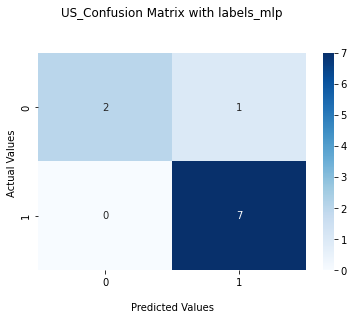

In [90]:
print('US_Test accuracy:', US_test_acc)
print("confusion_matrix_US")
ax = sns.heatmap(US_cf_matrix, annot=True, cmap='Blues')
ax.set_title('US_Confusion Matrix with labels_mlp\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

WN_Test accuracy: 0.3333333432674408
confusion_matrix_WN


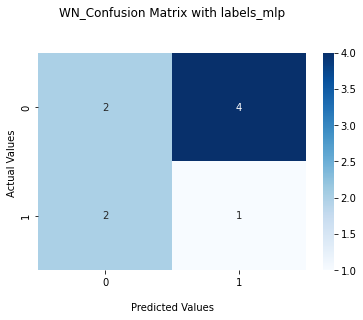

In [91]:
print('WN_Test accuracy:', WN_test_acc)
print("confusion_matrix_WN")
ax = sns.heatmap(WN_cf_matrix, annot=True, cmap='Blues')
ax.set_title('WN_Confusion Matrix with labels_mlp\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

In [75]:
def lstm_model(df,n_features):
    X,y=data_prep(df,n_features)
    X = X.reshape((X.shape[0],n_timesteps,n_features))
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    input_shape=(n_timesteps,n_features)
    K.clear_session
    model = Sequential([
      LSTM(50, activation='relu',return_sequences=True,input_shape=input_shape),
      Dropout(0.2),
      LSTM(20, activation='relu',input_shape=input_shape),
      Dropout(0.2),
      Dense(1,kernel_initializer='normal',activation = 'sigmoid')                      
    ])             

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    history=model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=16,
        
    )
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("\n")
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    y_pred = model.predict(x_test)
    print(y_test)
    y_pred = np.round(y_pred).astype(int)
    print(y_pred)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    return test_acc,cf_matrix

US_test_acc_lstm,US_cf_matrix_lstm=lstm_model(df_stable_US,n_features_US)
WN_test_acc_lstm,WN_cf_matrix_lstm=lstm_model(df_stable_WN,n_features_WN)

(31, 15) (31, 1)
Epoch 1/100


2022-06-12 20:47:30.771269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 132ms/step - loss: 0.6800 - accuracy: 0.6190
Epoch 2/100
2/2 [==============================] - 0s 51ms/step - loss: 0.6482 - accuracy: 0.6190
Epoch 3/100
2/2 [==============================] - 0s 49ms/step - loss: 0.6576 - accuracy: 0.6190
Epoch 4/100
2/2 [==============================] - 0s 50ms/step - loss: 0.6919 - accuracy: 0.6190
Epoch 5/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6189 - accuracy: 0.6190
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6631 - accuracy: 0.6190
Epoch 7/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6921 - accuracy: 0.6190
Epoch 8/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6618 - accuracy: 0.6190
Epoch 9/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6182 - accuracy: 0.6190
Epoch 10/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6598 - accuracy: 0.6190
Epoch 11/100
2/2 [============

Epoch 84/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1717 - accuracy: 0.9048
Epoch 85/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1220 - accuracy: 1.0000
Epoch 86/100
2/2 [==============================] - 0s 38ms/step - loss: 0.1401 - accuracy: 0.9524
Epoch 87/100
2/2 [==============================] - 0s 38ms/step - loss: 0.3408 - accuracy: 0.8571
Epoch 88/100
2/2 [==============================] - 0s 39ms/step - loss: 0.1223 - accuracy: 1.0000
Epoch 89/100
2/2 [==============================] - 0s 39ms/step - loss: 0.1041 - accuracy: 1.0000
Epoch 90/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0628 - accuracy: 1.0000
Epoch 91/100
2/2 [==============================] - 0s 45ms/step - loss: 0.1051 - accuracy: 1.0000
Epoch 92/100
2/2 [==============================] - 0s 45ms/step - loss: 0.1976 - accuracy: 0.9524
Epoch 93/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0599 - accuracy: 1.0000
Epoch 94/1

2022-06-12 20:47:40.013529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.6765872836112976
Test accuracy: 0.800000011920929
[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]]
(30, 12) (30, 1)
Epoch 1/100


2022-06-12 20:47:40.250835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 20:47:41.296181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 133ms/step - loss: 0.7168 - accuracy: 0.4286
Epoch 2/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6749 - accuracy: 0.6190
Epoch 3/100
2/2 [==============================] - 0s 52ms/step - loss: 0.6802 - accuracy: 0.5714
Epoch 4/100
2/2 [==============================] - 0s 54ms/step - loss: 0.6790 - accuracy: 0.6190
Epoch 5/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6974 - accuracy: 0.5714
Epoch 6/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6691 - accuracy: 0.5714
Epoch 7/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6871 - accuracy: 0.4286
Epoch 8/100
2/2 [==============================] - 0s 49ms/step - loss: 0.7133 - accuracy: 0.4762
Epoch 9/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6975 - accuracy: 0.5714
Epoch 10/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6883 - accuracy: 0.4762
Epoch 11/100
2/2 [============

Epoch 84/100
2/2 [==============================] - 0s 42ms/step - loss: 0.4444 - accuracy: 0.8095
Epoch 85/100
2/2 [==============================] - 0s 41ms/step - loss: 0.3535 - accuracy: 0.8571
Epoch 86/100
2/2 [==============================] - 0s 41ms/step - loss: 0.4029 - accuracy: 0.8095
Epoch 87/100
2/2 [==============================] - 0s 42ms/step - loss: 0.3386 - accuracy: 0.9048
Epoch 88/100
2/2 [==============================] - 0s 39ms/step - loss: 0.3755 - accuracy: 0.8571
Epoch 89/100
2/2 [==============================] - 0s 39ms/step - loss: 0.3868 - accuracy: 0.8095
Epoch 90/100
2/2 [==============================] - 0s 40ms/step - loss: 0.3932 - accuracy: 0.7619
Epoch 91/100
2/2 [==============================] - 0s 39ms/step - loss: 0.3632 - accuracy: 0.8095
Epoch 92/100
2/2 [==============================] - 0s 39ms/step - loss: 0.2909 - accuracy: 0.8571
Epoch 93/100
2/2 [==============================] - 0s 38ms/step - loss: 0.2826 - accuracy: 0.8571
Epoch 94/1

2022-06-12 20:47:50.542603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 1.3355075120925903
Test accuracy: 0.5555555820465088
[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]


2022-06-12 20:47:50.756300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


US_Test accuracy: 0.800000011920929
confusion_matrix_US


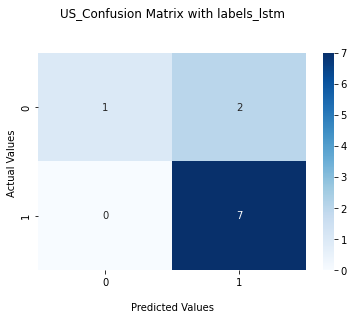

In [76]:
print('US_Test accuracy:', US_test_acc_lstm)
print("confusion_matrix_US")
ax = sns.heatmap(US_cf_matrix_lstm, annot=True, cmap='Blues')
ax.set_title('US_Confusion Matrix with labels_lstm\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

WN_Test accuracy: 0.5555555820465088
confusion_matrix_WN


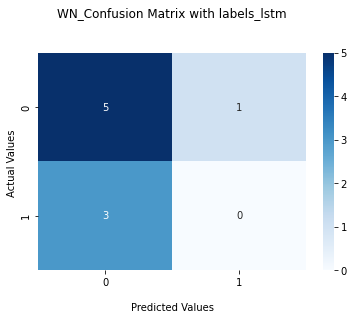

In [77]:
print('WN_Test accuracy:', WN_test_acc_lstm)
print("confusion_matrix_WN")
ax = sns.heatmap(WN_cf_matrix_lstm, annot=True, cmap='Blues')
ax.set_title('WN_Confusion Matrix with labels_lstm\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

In [11]:
cv = LeaveOneOut()

from sklearn.metrics import accuracy_score
error_scores_US=[]
error_scores_WN=[]
#kfold = KFold(n_splits=5)

def mlp_model(X_train, y_train,X_test,y_test):
    #input_shape=X_train.shape[1]
    #print(input_shape)
    model = keras.Sequential([
    
    keras.layers.Flatten(input_shape=(X_train.shape[1],)), #input_shape=(15,)

    keras.layers.Dense(16, activation=tf.nn.relu),

    keras.layers.Dense(16, activation=tf.nn.relu),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),

    ])


    model.compile(optimizer='adam',

                  loss='binary_crossentropy',

                  metrics=['accuracy'])


    model.fit(X_train, y_train, epochs=100,batch_size=1)#batch_size=32
    yhat=model.predict(X_test)
    test_loss, test_acc = model.evaluate(X_test, y_test,verbose=0)
    
    print("\n")
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    print('True Label:', y_test)
    print('Predicted Label:', yhat)
    print("\n")

    return test_acc



    #print('Test accuracy:', test_acc)

def loocv(df,n_features,error_scores):
    X,y=data_prep(df,n_features)
    #input_shape=n_timesteps,n_features
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X):
        print("TRAIN:", train_ix, "TEST:", test_ix)
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        #input_shape=X_train.shape[1]
        # fit model
        test_acc= mlp_model(X_train, y_train,X_test,y_test)
        #model.fit(X_train, y_train)
        # evaluate model
        #test_loss, test_acc = model.evaluate(X_test, y_test,verbose = 0)
        # store
        error_scores.append(test_acc)
    return error_scores

US_error_scores=loocv(df_stable_US,n_features_US,error_scores_US)
WN_error_scores=loocv(df_stable_WN,n_features_WN,error_scores_WN)

(31, 15) (31, 1)
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [0]
Epoch 1/100
28/30 [===========================>..] - ETA: 0s - loss: 0.5288 - accuracy: 0.7500

2022-06-12 15:43:46.999449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5554 - accuracy: 0.7333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5355 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4851 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4876 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4057 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4261 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4288 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4224 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4151 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1334 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0921 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1019 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1059 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:43:58.175693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00012229177809786052
Test accuracy: 1.0
True Label: [[0]]
Predicted Label: [[0.00012229]]


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [1]
Epoch 1/100


2022-06-12 15:43:58.472311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:43:58.660726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.7958 - accuracy: 0.7000
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4103 - accuracy: 0.8667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4199 - accuracy: 0.8667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4318 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4096 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4258 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3904 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3470 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3652 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.9333
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0956 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0813 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0885 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0860 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0956 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1023 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0530 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:44:10.040007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:44:10.101633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/30 [========================>.....] - ETA: 0s - loss: 0.5110 - accuracy: 0.8800

2022-06-12 15:44:10.297665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.8333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5846 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5214 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4818 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4848 - accuracy: 0.7333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4804 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4138 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4383 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4230 - accuracy: 0.8000
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0995 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0976 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0960 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1026 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0934 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0907 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0850 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0885 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0866 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0755 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:44:21.530361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:44:21.593451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/30 [=========================>....] - ETA: 0s - loss: 0.5600 - accuracy: 0.7692

2022-06-12 15:44:21.793375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.7667
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5255 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5124 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5217 - accuracy: 0.7333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4639 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4182 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4034 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4477 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4031 - accuracy: 0.8000
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1091 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0826 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.9333
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1146 - accuracy: 0.9333
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0757 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0956 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0722 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0956 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0682 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:44:33.058994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:44:33.122803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5375 - accuracy: 0.8667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0098 - accuracy: 1.0000

2022-06-12 15:44:33.324221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4707 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4715 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4279 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4446 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4392 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4217 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4086 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4715 - accuracy: 0.7667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.1132 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1365 - accuracy: 0.9333
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1303 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1364 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1186 - accuracy: 0.9333
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1145 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1375 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1184 - accuracy: 0.9667
Epoch 94/100


2022-06-12 15:44:44.469245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:44:44.531525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6671 - accuracy: 0.8000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1076 - accuracy: 1.0000

2022-06-12 15:44:44.728485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5776 - accuracy: 0.8667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5130 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4651 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4398 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4445 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4091 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3833 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3746 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3460 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0559 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0481 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0635 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0527 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0543 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:44:55.896247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:44:55.956016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.7798 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1109 - accuracy: 1.0000

2022-06-12 15:44:56.145189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5421 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4968 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4811 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4890 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4568 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4323 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4159 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4806 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4922 - accuracy: 0.7667
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3915 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.1188 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1307 - accuracy: 0.9333
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1406 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1483 - accuracy: 0.9333
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1060 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1122 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1269 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1006 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1015 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:45:07.269682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:45:07.329913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4519 - accuracy: 0.8333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1246 - accuracy: 1.0000

2022-06-12 15:45:07.523763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.4518 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4284 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3717 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3729 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3303 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3278 - accuracy: 0.9000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3124 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3373 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.2936 - accuracy: 0.8667
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.2704 - accuracy: 0.9000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0231 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0217 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0171 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:45:18.713820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:45:18.775498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5227 - accuracy: 0.8667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.9952 - accuracy: 0.0000e+00

2022-06-12 15:45:18.971216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5247 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4780 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3802 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3943 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3776 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4255 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3660 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3742 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3658 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3035 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0752 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0689 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0862 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0512 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0713 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0503 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:45:30.034719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:45:30.096326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.8000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0786 - accuracy: 1.0000

2022-06-12 15:45:30.292211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5552 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4401 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4962 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4366 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3925 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4145 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3908 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4097 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0942 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1076 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1034 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1166 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1025 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0897 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0765 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0737 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 0.9667
Epoch 94/100


2022-06-12 15:45:41.513676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:45:41.576855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.8000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0817 - accuracy: 1.0000

2022-06-12 15:45:41.771805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5270 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4439 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4736 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5312 - accuracy: 0.6667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4690 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3924 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 7ms/step - loss: 0.4153 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3978 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 5ms/step - loss: 0.1013 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1397 - accuracy: 0.9333
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0964 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0890 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0676 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0752 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0908 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0935 - accuracy: 0.9667
Epoch 94/100


2022-06-12 15:45:54.285006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:45:54.360848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/30 [======================>.......] - ETA: 0s - loss: 0.5290 - accuracy: 0.7826   

2022-06-12 15:45:54.968997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 5ms/step - loss: 0.5641 - accuracy: 0.7333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5370 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4629 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4479 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4415 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4259 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4038 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4403 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3723 - accuracy: 0.8000
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0971 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0890 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1004 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0910 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1116 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1339 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1238 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0857 - accuracy: 0.9333
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0953 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:46:06.702001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:46:06.766352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5878 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.0136 - accuracy: 1.0000

2022-06-12 15:46:06.962805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5224 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4757 - accuracy: 0.8667
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4957 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4787 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4776 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4470 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3835 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3675 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4097 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3453 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0838 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0853 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0876 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0762 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0756 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0750 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0763 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0683 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:46:18.079463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:46:18.141011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/30 [=======================>......] - ETA: 0s - loss: 0.6035 - accuracy: 0.7500

2022-06-12 15:46:18.333111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5672 - accuracy: 0.7667
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5889 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5015 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4681 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4822 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4848 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4299 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3750 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4954 - accuracy: 0.8000
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0680 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0734 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0577 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0576 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0688 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 0.9333
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0508 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.9667
Epoch 93/100


2022-06-12 15:46:29.630043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:46:29.692349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
 9/30 [========>.....................] - ETA: 0s - loss: 0.8566 - accuracy: 0.7778

2022-06-12 15:46:29.997026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 5ms/step - loss: 0.7014 - accuracy: 0.7333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4783 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5742 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4935 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 7ms/step - loss: 0.4305 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4273 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4057 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3934 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3742 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1064 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1475 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1734 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0890 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0940 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0792 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0785 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1034 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:46:41.368778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:46:41.432455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/30 [==========================>...] - ETA: 0s - loss: 0.7529 - accuracy: 0.7407

2022-06-12 15:46:41.636856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.7354 - accuracy: 0.7000
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5041 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4578 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4849 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5225 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4106 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4181 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4115 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4017 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1023 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1027 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0985 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0728 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0847 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0842 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0745 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0773 - accuracy: 0.9667
Epoch 93/100


2022-06-12 15:46:52.854241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.12631410360336304
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.88133794]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] TEST: [16]
Epoch 1/100


2022-06-12 15:46:53.093650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:46:53.287535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.8302 - accuracy: 0.7333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4787 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4508 - accuracy: 0.7667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5195 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4117 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4030 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4560 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4178 - accuracy: 0.7667
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1231 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1225 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1366 - accuracy: 0.9333
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0944 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1049 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1170 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0861 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1013 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:47:04.494340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:47:04.556717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.8000
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 3.3186 - accuracy: 0.0000e+00

2022-06-12 15:47:04.751377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5396 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5415 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4422 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4616 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4938 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4125 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3880 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3930 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3789 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.1402 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0944 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0923 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1170 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1057 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1024 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9667
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0892 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:47:16.144575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:47:16.206066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6650 - accuracy: 0.8333
Epoch 2/100


2022-06-12 15:47:16.407474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5484 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5036 - accuracy: 0.7667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5031 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4262 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4422 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4117 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4247 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4139 - accuracy: 0.7667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3977 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3807 - accuracy: 0.8667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.0880 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0891 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0739 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0958 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0922 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0616 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9667
Epoch 94/100


2022-06-12 15:47:28.132278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:47:28.201358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5742 - accuracy: 0.8000
Epoch 2/100


2022-06-12 15:47:28.405609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.4338 - accuracy: 0.8667
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3878 - accuracy: 0.8667
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4004 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3788 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3876 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4118 - accuracy: 0.8667
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3637 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3147 - accuracy: 0.8667
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3417 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0390 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0375 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0467 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0350 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0362 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0369 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0360 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0312 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:47:40.539619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:47:40.603112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/30 [=======================>......] - ETA: 0s - loss: 0.5379 - accuracy: 0.8333  

2022-06-12 15:47:40.825803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.8000
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5037 - accuracy: 0.8000
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4362 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4744 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4260 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4304 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 7ms/step - loss: 0.4104 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4123 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4000 - accuracy: 0.8667
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0938 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0929 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1222 - accuracy: 0.9333
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1226 - accuracy: 0.9333
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1807 - accuracy: 0.8667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1179 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.2091 - accuracy: 0.9000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1695 - accuracy: 0.9000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1582 - accuracy: 0.9333
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1260 - accuracy: 0.9333
Epoch 93/100


2022-06-12 15:47:54.233791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:47:54.306222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.8333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.2845 - accuracy: 1.0000

2022-06-12 15:47:54.512871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 3ms/step - loss: 0.5809 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4635 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4545 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4141 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4475 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3988 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4066 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3867 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3422 - accuracy: 0.8333
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3460 - accuracy: 0.8333
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0507 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0538 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0580 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0495 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0451 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0473 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:48:07.984336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:48:08.063143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/30 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.7931  

2022-06-12 15:48:08.280725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6007 - accuracy: 0.8000
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5214 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4515 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4407 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4519 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4675 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4610 - accuracy: 0.8333
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4636 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5239 - accuracy: 0.7667
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.9333
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1354 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1024 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1006 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1128 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1049 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1063 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0973 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:48:19.953429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:48:20.016232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/30 [=============>................] - ETA: 0s - loss: 0.6364 - accuracy: 0.7857    

2022-06-12 15:48:20.222973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.7333
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4976 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4944 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4712 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4383 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4287 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4322 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4111 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4238 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4294 - accuracy: 0.8000
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1776 - accuracy: 0.9000
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0911 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0866 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0876 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0766 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0918 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0805 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1009 - accuracy: 0.9667
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1029 - accuracy: 0.9667
Epoch 93/100


2022-06-12 15:48:33.684379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:48:33.772276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00032977465889416635
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99967027]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30] TEST: [24]
Epoch 1/100
 1/30 [>.............................] - ETA: 9s - loss: 7.2471 - accuracy: 0.0000e+00

2022-06-12 15:48:34.061223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 7ms/step - loss: 0.7865 - accuracy: 0.6667
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5929 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5083 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4423 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4340 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4392 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4538 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4446 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4405 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3875 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 3ms/step - loss: 0.1177 - accuracy: 0.9667
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1313 - accuracy: 0.9000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0777 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0906 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0774 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0678 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0605 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0938 - accuracy: 0.9667
Epoch 93/100


2022-06-12 15:48:45.936364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:48:46.012023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/30 [=============>................] - ETA: 0s - loss: 0.6246 - accuracy: 0.7857

2022-06-12 15:48:46.226382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.7667
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5416 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4751 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4690 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5550 - accuracy: 0.7000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5130 - accuracy: 0.8667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4470 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4105 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3906 - accuracy: 0.8000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.8667
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1020 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1107 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0956 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0953 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0838 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0793 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0777 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:48:57.635545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 0.00032275114790536463
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.9996773]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30] TEST: [26]
Epoch 1/100


2022-06-12 15:48:58.050233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:48:58.245759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.7333
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.8333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4929 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4806 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4550 - accuracy: 0.8000
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4396 - accuracy: 0.8000
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3991 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3854 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3655 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1562 - accuracy: 0.9000
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0835 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0981 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0878 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.9333
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1121 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1027 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0966 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 1.0000
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:49:09.373567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:49:09.435635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.7333
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.1534 - accuracy: 1.0000

2022-06-12 15:49:09.635552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5649 - accuracy: 0.8000
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5310 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4689 - accuracy: 0.8667
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4399 - accuracy: 0.8667
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4586 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4405 - accuracy: 0.7667
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4200 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4138 - accuracy: 0.8667
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3961 - accuracy: 0.8667
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4477 - accuracy: 0.8000
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 3ms/step - loss: 0.1316 - accuracy: 0.9667
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1025 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0936 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1106 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0932 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1052 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0826 - accuracy: 1.0000
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0775 - accuracy: 1.0000
Epoch 94/100


2022-06-12 15:49:20.648465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:49:20.709904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.7667
Epoch 2/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6013 - accuracy: 1.0000

2022-06-12 15:49:20.916672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.5676 - accuracy: 0.7667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5586 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4692 - accuracy: 0.8000
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.8000
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4762 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5045 - accuracy: 0.7667
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.3613 - accuracy: 0.9000
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4128 - accuracy: 0.8000
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4001 - accuracy: 0.8667
Epoch 12/100
30/30 [

30/30 [==============================] - 0s 4ms/step - loss: 0.0725 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0876 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0900 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1040 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1615 - accuracy: 0.9333
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1251 - accuracy: 0.9333
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1026 - accuracy: 0.9333
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1530 - accuracy: 0.9333
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0958 - accuracy: 0.9667
Epoch 94/100


2022-06-12 15:49:32.154696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:49:32.215956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/30 [===========================>..] - ETA: 0s - loss: 0.6771 - accuracy: 0.7857  

2022-06-12 15:49:32.409640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.8000
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5712 - accuracy: 0.8667
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4604 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4649 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4831 - accuracy: 0.7667
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4179 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4549 - accuracy: 0.8667
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4374 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4268 - accuracy: 0.8000
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.1490 - accuracy: 0.9333
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1573 - accuracy: 0.9333
Epoch 85/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0955 - accuracy: 1.0000
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 1.0000
Epoch 87/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 1.0000
Epoch 88/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9667
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0994 - accuracy: 1.0000
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1096 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0987 - accuracy: 1.0000
Epoch 93/100


2022-06-12 15:49:43.707388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:49:43.771598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/30 [===========================>..] - ETA: 0s - loss: 0.7518 - accuracy: 0.7857  

2022-06-12 15:49:43.982518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 4ms/step - loss: 0.7237 - accuracy: 0.8000
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.7333
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5059 - accuracy: 0.8333
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4964 - accuracy: 0.8333
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4522 - accuracy: 0.8333
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.4432 - accuracy: 0.8333
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4223 - accuracy: 0.8333
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4058 - accuracy: 0.8000
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4036 - accuracy: 0.8333
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4118 - accuracy: 0.8333
Epoch 11/100
30/30 [=

30/30 [==============================] - 0s 4ms/step - loss: 0.0901 - accuracy: 1.0000
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1080 - accuracy: 1.0000
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9667
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1132 - accuracy: 0.9667
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0915 - accuracy: 0.9667
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0896 - accuracy: 1.0000
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0860 - accuracy: 0.9667
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1089 - accuracy: 1.0000
Epoch 91/100
30/30 [==============================] - 0s 4ms/step - loss: 0.1237 - accuracy: 0.9667
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0991 - accuracy: 0.9667
Epoch 93/100


2022-06-12 15:49:55.098027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 5.007352592656389e-05
Test accuracy: 1.0
True Label: [[1]]
Predicted Label: [[0.99994993]]


(30, 12) (30, 1)
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] TEST: [0]
Epoch 1/100


2022-06-12 15:49:55.343777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:49:55.541811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.1314 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.7809 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.6933 - accuracy: 0.3103
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.7396 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1986 - accuracy: 0.3793
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9556 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9333 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9829 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8614 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0132 - accuracy: 0.5517
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5637 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5519 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5642 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7200 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5862
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6897
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5893 - accuracy: 0.5862
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5732 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5791 - accuracy: 0.6897
Epoch 93/100


2022-06-12 15:50:06.061158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:50:06.123121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.1197 - accuracy: 0.5517
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2022-06-12 15:50:06.315912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 7.1169 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.3626 - accuracy: 0.4828
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.6452 - accuracy: 0.3103
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.2523 - accuracy: 0.2759
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9910 - accuracy: 0.4138
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9987 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7265 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7453 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7663 - accuracy: 0.5172
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7567 - accuracy: 0.5862
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5738 - accuracy: 0.6207
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6693 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5352 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5251 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5532 - accuracy: 0.6207
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5829 - accuracy: 0.6897
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5743 - accuracy: 0.6897
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.6207
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5336 - accuracy: 0.6897
Epoch 94/100


2022-06-12 15:50:16.957497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:50:17.020130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.8482 - accuracy: 0.5517
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 20.0697 - accuracy: 0.0000e+00

2022-06-12 15:50:17.213865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 6.7662 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.4516 - accuracy: 0.4828
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.7989 - accuracy: 0.4828
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.4674 - accuracy: 0.3103
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0626 - accuracy: 0.4483
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8860 - accuracy: 0.4828
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0300 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7422 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8586 - accuracy: 0.5172
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8165 - accuracy: 0.5517
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5279 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5187 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5286 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5783 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5397 - accuracy: 0.6897
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5938 - accuracy: 0.6552
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5057 - accuracy: 0.6897
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5887 - accuracy: 0.6207
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6033 - accuracy: 0.6897
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5523 - accuracy: 0.7241
Epoch 94/100


2022-06-12 15:50:27.834134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:50:27.894745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/29 [=============>................] - ETA: 0s - loss: 20.3279 - accuracy: 0.3571    

2022-06-12 15:50:28.094558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.9911 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.9586 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.7909 - accuracy: 0.3793
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.9784 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.3506 - accuracy: 0.3448
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1899 - accuracy: 0.2759
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1316 - accuracy: 0.4483
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9504 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8885 - accuracy: 0.4483
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7458 - accuracy: 0.6207
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5477 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5478 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5615 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5737 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5048 - accuracy: 0.6552
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5062 - accuracy: 0.6897
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5832 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5324 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5264 - accuracy: 0.6897
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5266 - accuracy: 0.6897
Epoch 93/100


2022-06-12 15:50:38.695183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:50:38.759433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/29 [============>.................] - ETA: 0s - loss: 16.7419 - accuracy: 0.4615   

2022-06-12 15:50:38.955752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.3686 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 7.2943 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.1859 - accuracy: 0.4483
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.8023 - accuracy: 0.3793
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.3658 - accuracy: 0.4483
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0053 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8577 - accuracy: 0.4138
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7603 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7456 - accuracy: 0.5517
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5915 - accuracy: 0.6552
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5642 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.5862
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5512 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5080 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5703 - accuracy: 0.6552
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5547 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5566 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5121 - accuracy: 0.6897
Epoch 93/100


2022-06-12 15:50:49.933439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:50:49.994048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.1763 - accuracy: 0.5862
Epoch 2/100


2022-06-12 15:50:50.188667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 6.5251 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.2010 - accuracy: 0.4483
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.6459 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1700 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9650 - accuracy: 0.5517
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9629 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9155 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0898 - accuracy: 0.4828
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8608 - accuracy: 0.5862
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7685 - accuracy: 0.5172
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6552
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5538 - accuracy: 0.7241
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5744 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5887 - accuracy: 0.6552
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5711 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5766 - accuracy: 0.6897
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5082 - accuracy: 0.6897
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5529 - accuracy: 0.6552
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6741 - accuracy: 0.7241
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5349 - accuracy: 0.7586
Epoch 94/100


2022-06-12 15:51:01.196483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:51:01.259907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.1331 - accuracy: 0.5862
Epoch 2/100


2022-06-12 15:51:01.453473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 6.6513 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.2816 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.5332 - accuracy: 0.4828
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0057 - accuracy: 0.3793
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8551 - accuracy: 0.5517
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8153 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7758 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7237 - accuracy: 0.5172
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5488 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5726 - accuracy: 0.6552
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.6552
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5375 - accuracy: 0.6552
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7892 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6552
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6038 - accuracy: 0.5862
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5714 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6087 - accuracy: 0.6897
Epoch 94/100


2022-06-12 15:52:18.561671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:52:18.624180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.4590 - accuracy: 0.5517
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 35.2250 - accuracy: 0.0000e+00

2022-06-12 15:52:18.822951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 7.2560 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.9237 - accuracy: 0.4138
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.5722 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.5335 - accuracy: 0.4138
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9348 - accuracy: 0.4828
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8818 - accuracy: 0.5172
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9834 - accuracy: 0.4828
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7344 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7518 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7789 - accuracy: 0.5172
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5370 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5637 - accuracy: 0.7241
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.7241
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5569 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5630 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5788 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5616 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5944 - accuracy: 0.6207
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5334 - accuracy: 0.7586
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5743 - accuracy: 0.7241
Epoch 94/100


2022-06-12 15:52:29.450111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:52:29.511600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/29 [=====================>........] - ETA: 0s - loss: 15.6157 - accuracy: 0.5000   

2022-06-12 15:52:29.714998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 13.1483 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 6.8227 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.1920 - accuracy: 0.4138
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.4865 - accuracy: 0.4138
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1486 - accuracy: 0.4828
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8323 - accuracy: 0.4828
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7857 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.6552
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8141 - accuracy: 0.5517
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5862
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5712 - accuracy: 0.6207
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5811 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5794 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7442 - accuracy: 0.6897
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5453 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6552
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5588 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5131 - accuracy: 0.6552
Epoch 93/100


2022-06-12 15:52:40.696531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:52:40.761159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 4ms/step - loss: 12.9476 - accuracy: 0.5862
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 21.4111 - accuracy: 0.0000e+00

2022-06-12 15:52:41.177161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 7.2571 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.8133 - accuracy: 0.3793
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.4789 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.1638 - accuracy: 0.3448
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8600 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8069 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7324 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7158 - accuracy: 0.5862
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6552
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.4408 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4804 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5181 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4255 - accuracy: 0.7931
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4448 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4506 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4447 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5258 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4394 - accuracy: 0.7931
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.7586
Epoch 94/100


2022-06-12 15:52:51.742938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:52:51.804050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/29 [==========================>...] - ETA: 0s - loss: 12.8926 - accuracy: 0.5556  

2022-06-12 15:52:52.022652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.0035 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.5852 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 1.9645 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6181 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0485 - accuracy: 0.3103
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8516 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7207 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7719 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7886 - accuracy: 0.4483
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.6552
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5556 - accuracy: 0.6552
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.6897
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5747 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4991 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5690 - accuracy: 0.6552
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6049 - accuracy: 0.6207
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5535 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5155 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6897
Epoch 93/100


2022-06-12 15:53:02.515819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:53:02.577465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.2265 - accuracy: 0.5517
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 19.5306 - accuracy: 0.0000e+00

2022-06-12 15:53:02.775474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 7.0099 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 1.8104 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 2.2849 - accuracy: 0.2759
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.3046 - accuracy: 0.4138
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8643 - accuracy: 0.6207
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8460 - accuracy: 0.5172
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7940 - accuracy: 0.4828
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7774 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7788 - accuracy: 0.5862
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5763 - accuracy: 0.6552
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5801 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4909 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4898 - accuracy: 0.8276
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5432 - accuracy: 0.8276
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5107 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5456 - accuracy: 0.6897
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4774 - accuracy: 0.7586
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5267 - accuracy: 0.7586
Epoch 94/100


2022-06-12 15:53:13.555098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:53:13.617801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/29 [===========================>..] - ETA: 0s - loss: 11.6865 - accuracy: 0.5714  

2022-06-12 15:53:13.818895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.4639 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.3384 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.3487 - accuracy: 0.3793
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.5584 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1316 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.1092 - accuracy: 0.4138
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9156 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8035 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8202 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7362 - accuracy: 0.6207
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5679 - accuracy: 0.6552
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5859 - accuracy: 0.6897
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5837 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5675 - accuracy: 0.6207
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5499 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5661 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5424 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5126 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5218 - accuracy: 0.6552
Epoch 93/100


2022-06-12 15:53:24.252051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:53:24.315893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/29 [============>.................] - ETA: 0s - loss: 16.6613 - accuracy: 0.4615    

2022-06-12 15:53:24.516676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.9551 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.6056 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.2238 - accuracy: 0.4828
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.4821 - accuracy: 0.3793
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0848 - accuracy: 0.5862
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9217 - accuracy: 0.4483
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7772 - accuracy: 0.4828
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7838 - accuracy: 0.4828
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.6552
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5273 - accuracy: 0.7241
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5333 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5752 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7757 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8025 - accuracy: 0.6552
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5296 - accuracy: 0.6897
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5018 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5479 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5361 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5686 - accuracy: 0.6552
Epoch 93/100


2022-06-12 15:53:35.241702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:53:35.306630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/29 [============>.................] - ETA: 0s - loss: 9.4725 - accuracy: 0.6923    

2022-06-12 15:53:35.508220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.4434 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 7.2207 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.3573 - accuracy: 0.2759
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.9286 - accuracy: 0.3103
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.3212 - accuracy: 0.4138
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.2865 - accuracy: 0.4828
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1002 - accuracy: 0.5172
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8262 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9017 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8870 - accuracy: 0.6207
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.5862
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5323 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5935 - accuracy: 0.5862
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5425 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5464 - accuracy: 0.6552
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.5517
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5729 - accuracy: 0.6552
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.6552
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5341 - accuracy: 0.7586
Epoch 93/100


2022-06-12 15:53:46.311342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:53:46.372456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.0032 - accuracy: 0.5517
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2022-06-12 15:53:46.561446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 3ms/step - loss: 7.0045 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.7697 - accuracy: 0.3103
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.7002 - accuracy: 0.4138
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1469 - accuracy: 0.4138
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8725 - accuracy: 0.4828
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8474 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7959 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.6552
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.7241
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4440 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4858 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5327 - accuracy: 0.6552
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5087 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4643 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4743 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4242 - accuracy: 0.8276
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5061 - accuracy: 0.7586
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4726 - accuracy: 0.7241
Epoch 94/100


2022-06-12 15:53:57.280837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:53:57.341160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/29 [=========================>....] - ETA: 0s - loss: 10.9557 - accuracy: 0.6154  

2022-06-12 15:53:57.535662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.4426 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.2022 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.2955 - accuracy: 0.3448
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6510 - accuracy: 0.3793
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.0295 - accuracy: 0.4483
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9070 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9343 - accuracy: 0.4828
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7659 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9577 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8210 - accuracy: 0.5517
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5779 - accuracy: 0.7931
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.6552
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.5862
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5719 - accuracy: 0.7241
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5454 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6552
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5488 - accuracy: 0.7586
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5836 - accuracy: 0.6552
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7904 - accuracy: 0.5517
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5988 - accuracy: 0.6897
Epoch 93/100


2022-06-12 15:54:08.336782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:54:08.400566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/29 [==========================>...] - ETA: 0s - loss: 14.5020 - accuracy: 0.5185  

2022-06-12 15:54:08.600324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.5019 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.9390 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.7563 - accuracy: 0.4138
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.7896 - accuracy: 0.4138
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1756 - accuracy: 0.3103
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8243 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7792 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7405 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7736 - accuracy: 0.5172
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5528 - accuracy: 0.7586
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5841 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5380 - accuracy: 0.7241
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5352 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6107 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5630 - accuracy: 0.6207
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.6207
Epoch 93/100


2022-06-12 15:54:19.211804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:54:19.275703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/29 [==========================>...] - ETA: 0s - loss: 12.1277 - accuracy: 0.5926   

2022-06-12 15:54:19.480011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.0616 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 6.6847 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.5057 - accuracy: 0.4483
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.6602 - accuracy: 0.4828
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1852 - accuracy: 0.5172
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9073 - accuracy: 0.6552
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8008 - accuracy: 0.5172
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7415 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8891 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.7241
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5617 - accuracy: 0.7931
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5223 - accuracy: 0.6552
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5270 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5119 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4994 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5177 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5360 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5179 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4653 - accuracy: 0.6897
Epoch 93/100


2022-06-12 15:54:30.157995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 15:54:30.221939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 13.1100 - accuracy: 0.5517


2022-06-12 15:54:30.600742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 6.8714 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 2.5057 - accuracy: 0.4483
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6681 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9956 - accuracy: 0.3793
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.9387 - accuracy: 0.4483
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.4828
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5862
Epoch 9/100
29/29 [==============================] - 0s 6ms/step - loss: 0.7852 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.6207
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6661 - accuracy: 0.6207
Epoch 12

Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4944 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4547 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4363 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4414 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4728 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4156 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4984 - accuracy: 0.7931
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4405 - accuracy: 0.8276
Epoch 93/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4179 - accuracy: 0.7931


2022-06-12 16:10:47.492418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:10:47.565010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 11.8816 - accuracy: 0.5862
Epoch 2/100
 1/29 [>.............................] - ETA: 0s - loss: 1.6526e-07 - accuracy: 1.0000

2022-06-12 16:10:47.755975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 6.2295 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.1878 - accuracy: 0.5517
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.5679 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.2234 - accuracy: 0.5172
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8633 - accuracy: 0.3103
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7858 - accuracy: 0.5172
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7186 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7597 - accuracy: 0.5517
Epoch 11/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7484 - accuracy: 0.6552
Epoch 12/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5665 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5620 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5475 - accuracy: 0.7241
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.6207
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5512 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5135 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5754 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6897
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5334 - accuracy: 0.7241
Epoch 93/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5439 - accuracy: 0.8276
Epoch 94/100


2022-06-12 16:45:16.448974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:45:16.510457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/29 [=========================>....] - ETA: 0s - loss: 11.1399 - accuracy: 0.6154   

2022-06-12 16:45:16.724671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.1304 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 3ms/step - loss: 6.3914 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.6681 - accuracy: 0.4138
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 1.6024 - accuracy: 0.3448
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.2210 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.1554 - accuracy: 0.3793
Epoch 7/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8469 - accuracy: 0.4483
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7365 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7819 - accuracy: 0.4828
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8074 - accuracy: 0.5172
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5455 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5324 - accuracy: 0.6897
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5856 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6897
Epoch 88/100
29/29 [==============================] - 0s 6ms/step - loss: 0.6183 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5938 - accuracy: 0.6552
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.6897
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5477 - accuracy: 0.7241
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5256 - accuracy: 0.7586
Epoch 93/100


2022-06-12 16:47:11.499876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:47:11.571481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/29 [=========>....................] - ETA: 0s - loss: 9.9926 - accuracy: 0.7000    

2022-06-12 16:47:11.826064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 12.4708 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.8276 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.9437 - accuracy: 0.4138
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.8297 - accuracy: 0.4138
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.4927 - accuracy: 0.3448
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 1.1756 - accuracy: 0.4828
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9100 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 6ms/step - loss: 1.1201 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7806 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 5ms/step - loss: 0.7493 - accuracy: 0.6552
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5909 - accuracy: 0.6552
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5613 - accuracy: 0.6897
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6207
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5592 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5540 - accuracy: 0.6552
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6552
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.6552
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.7241
Epoch 93/100


2022-06-12 16:47:24.197289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:47:24.273085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/29 [===========>..................] - ETA: 0s - loss: 20.8896 - accuracy: 0.4167   

2022-06-12 16:47:24.491596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 12.5695 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 7.0722 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.3748 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6513 - accuracy: 0.4483
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.3762 - accuracy: 0.3793
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.1492 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0368 - accuracy: 0.3448
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9092 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7617 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7203 - accuracy: 0.6207
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 0.5310 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5493 - accuracy: 0.7931
Epoch 85/100
29/29 [==============================] - 0s 5ms/step - loss: 0.5335 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5595 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5100 - accuracy: 0.7586
Epoch 88/100
29/29 [==============================] - 0s 3ms/step - loss: 0.7500 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5134 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5328 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.5862
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6897
Epoch 93/100


2022-06-12 16:47:36.400810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:47:36.466789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/29 [==========>...................] - ETA: 0s - loss: 11.0270 - accuracy: 0.6364    

2022-06-12 16:47:37.105176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 4ms/step - loss: 11.9698 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 6.6247 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.3837 - accuracy: 0.5862
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 1.6574 - accuracy: 0.3448
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 1.1491 - accuracy: 0.4828
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8236 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 0.8058 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7095 - accuracy: 0.6207
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7614 - accuracy: 0.6552
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.4971 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5251 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4582 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4483 - accuracy: 0.7931
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.6552
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5281 - accuracy: 0.7241
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4638 - accuracy: 0.7931
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4574 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5092 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4690 - accuracy: 0.7931
Epoch 93/100


2022-06-12 16:47:51.879786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:47:51.963366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




Test loss: 2.5191597938537598
Test accuracy: 0.0
True Label: [[1]]
Predicted Label: [[0.08052723]]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29] TEST: [25]
Epoch 1/100
 9/29 [========>.....................] - ETA: 0s - loss: 18.5899 - accuracy: 0.4444    

2022-06-12 16:47:52.365974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 11.6717 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 6.3741 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.2776 - accuracy: 0.4828
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6217 - accuracy: 0.3448
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0840 - accuracy: 0.4828
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8291 - accuracy: 0.5517
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.5862
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7716 - accuracy: 0.5517
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.6552
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5216 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5373 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5409 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6038 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5114 - accuracy: 0.8276
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4765 - accuracy: 0.7931
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5641 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5466 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6207
Epoch 92/100
29/29 [==============================] - 0s 5ms/step - loss: 0.5151 - accuracy: 0.6897
Epoch 93/100


2022-06-12 16:48:05.195820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:48:05.274270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/29 [==========>...................] - ETA: 0s - loss: 15.3611 - accuracy: 0.5455   

2022-06-12 16:48:05.504960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 13.4839 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 7.4348 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.6149 - accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.7623 - accuracy: 0.3103
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.3450 - accuracy: 0.4483
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0188 - accuracy: 0.4483
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9910 - accuracy: 0.4828
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8756 - accuracy: 0.5172
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9171 - accuracy: 0.5517
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7591 - accuracy: 0.5862
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5711 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5718 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 7ms/step - loss: 0.5927 - accuracy: 0.6552
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5644 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5535 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5278 - accuracy: 0.6207
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5742 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5374 - accuracy: 0.7241
Epoch 91/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5873 - accuracy: 0.6897
Epoch 92/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5226 - accuracy: 0.7586
Epoch 93/100


2022-06-12 16:48:17.526487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:48:17.592093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/29 [==========>...................] - ETA: 0s - loss: 13.4951 - accuracy: 0.5455    

2022-06-12 16:48:17.804744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 4ms/step - loss: 11.7022 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.7361 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.6537 - accuracy: 0.3103
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6774 - accuracy: 0.3448
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 1.2070 - accuracy: 0.5517
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.8400 - accuracy: 0.4138
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7835 - accuracy: 0.6552
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6666 - accuracy: 0.5862
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9992 - accuracy: 0.5172
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7267 - accuracy: 0.6897
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5873 - accuracy: 0.6552
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5638 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5067 - accuracy: 0.7931
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5276 - accuracy: 0.7586
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5145 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5302 - accuracy: 0.7586
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.6552
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.4911 - accuracy: 0.7931
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6897
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5701 - accuracy: 0.7586
Epoch 93/100


2022-06-12 16:48:28.873713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:48:28.940447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/29 [=========>....................] - ETA: 0s - loss: 15.2473 - accuracy: 0.6000    

2022-06-12 16:48:29.171471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step - loss: 13.1517 - accuracy: 0.5517
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 6.8981 - accuracy: 0.5517
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.2216 - accuracy: 0.4138
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.4568 - accuracy: 0.2759
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0807 - accuracy: 0.6207
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9589 - accuracy: 0.5862
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.8537 - accuracy: 0.5517
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9703 - accuracy: 0.6552
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7294 - accuracy: 0.6207
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5862
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5425 - accuracy: 0.6897
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5785 - accuracy: 0.7586
Epoch 85/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5449 - accuracy: 0.7586
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6572 - accuracy: 0.6552
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5318 - accuracy: 0.6897
Epoch 89/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5866 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5496 - accuracy: 0.7586
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5026 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5091 - accuracy: 0.7586
Epoch 93/100


2022-06-12 16:48:40.125724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:48:40.192794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/29 [===========>..................] - ETA: 0s - loss: 13.8875 - accuracy: 0.5833    

2022-06-12 16:48:40.700352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 4ms/step - loss: 12.3241 - accuracy: 0.5862
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 7.0523 - accuracy: 0.5862
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 2.7862 - accuracy: 0.3793
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.6314 - accuracy: 0.3448
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 1.0800 - accuracy: 0.4483
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7791 - accuracy: 0.5172
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7235 - accuracy: 0.6207
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7531 - accuracy: 0.6897
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7996 - accuracy: 0.5862
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.7751 - accuracy: 0.6897
Epoch 11/100
29/29 [

29/29 [==============================] - 0s 4ms/step - loss: 0.5487 - accuracy: 0.7241
Epoch 84/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5110 - accuracy: 0.7241
Epoch 85/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5367 - accuracy: 0.7241
Epoch 86/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5165 - accuracy: 0.6897
Epoch 87/100
29/29 [==============================] - 0s 3ms/step - loss: 0.4859 - accuracy: 0.7241
Epoch 88/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5619 - accuracy: 0.6897
Epoch 89/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.7241
Epoch 90/100
29/29 [==============================] - 0s 3ms/step - loss: 0.5593 - accuracy: 0.6552
Epoch 91/100
29/29 [==============================] - 0s 4ms/step - loss: 0.5027 - accuracy: 0.7586
Epoch 92/100
29/29 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6897
Epoch 93/100


2022-06-12 16:48:51.887030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-12 16:48:51.951740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [62]:
print("US_error")
print("--------")
print(US_error_scores)
US_error=np.mean(US_error_scores)
print("\n")
print(US_error)

US_error
--------
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.8064516129032258


In [63]:
print("\n")
print("WN_error")
print("--------")
print(WN_error_scores)
WN_error=np.mean(WN_error_scores)
print("\n")
print(WN_error)



WN_error
--------
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


0.5666666666666667
